# (08) MNIST — Poisson — 0

**Motivation**: Implement Poisson VAE, fit to MNIST. Note: this notebook used straight-through (ST) gradient estimator. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 100
activation = 'exp'
weight_norm = True

batch_size = 200
epochs = 300

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pvaest',
    device_idx=0,
    n_latents=n_latents,
    activation=activation,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonVAEST |  7.9 Mil   |
|     ---      |    ---     |
|     enc      |  6.6 Mil   |
|     dec      |  1.3 Mil   |
+--------------+------------+

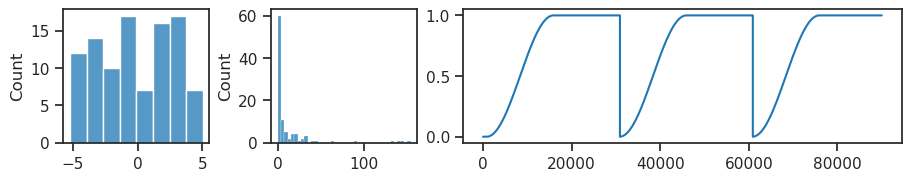

In [4]:
fig, axes = create_figure(1, 3, (9, 1.7), width_ratios=[1, 1, 3], layout='constrained')

sns.histplot(to_np(pvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['beta_values'])
plt.show()

## Train / Validate

### trn

In [5]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl = iteration(
        ep, pvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 153.3,  loss = (kl: 11.1, recon: 24.7  ——  tot: 35.83)  : 100%|████████████████████████| 300/300 [1:01:32<00:00, 12.31s/it]

CPU times: user 1h 32min 16s, sys: 35.1 s, total: 1h 32min 51s
Wall time: 1h 1min 32s


### vld

In [7]:
emb, labels, loss_vld = validate(pvae, vld, device)
loss_vld

{'kl': 11.152999951171873,
 'recon': 25.207129101562497,
 'tot': 36.36012905273437}

In [6]:
### Was beta=0.6, with enc act: 'exp'

{'kl': 17.94726452636719,
 'recon': 19.887100146484375,
 'tot': 30.655459423828123}

In [9]:
### Was with self.dt included

{'kl': 16.8736869140625, 'recon': 21.57813173828125, 'tot': 31.70234443359375}

In [8]:
### delta_t = [26.4626] —— Was n_latents = 100, beta=0.6, batch_size=200

{'kl': 4.683330206298828,
 'recon': 7.804767846679688,
 'tot': 10.614766052246093}

In [7]:
### Was n_latents = 1000, beta=0.6, batch_size=2000

{'kl': 16.87740234375, 'recon': 20.002710546875, 'tot': 30.12915234375}

In [7]:
### Was n_latents = 1000, beta=0.8, batch_size=2000

{'kl': 13.758321484375, 'recon': 22.255551953125, 'tot': 33.26221015625}

In [6]:
### Was n_latents = 1000, beta=0.7

{'kl': 14.2896685546875, 'recon': 23.304612499999998, 'tot': 33.30738007812501}

In [8]:
### Was n_latents = 1000, beta=0.2

{'kl': 34.055227929687504,
 'recon': 14.32718876953125,
 'tot': 21.138234472656254}

In [5]:
### Was n_latents = 100, beta=1.0

{'kl': 11.51728046875, 'recon': 24.29022021484375, 'tot': 35.80750117187499}

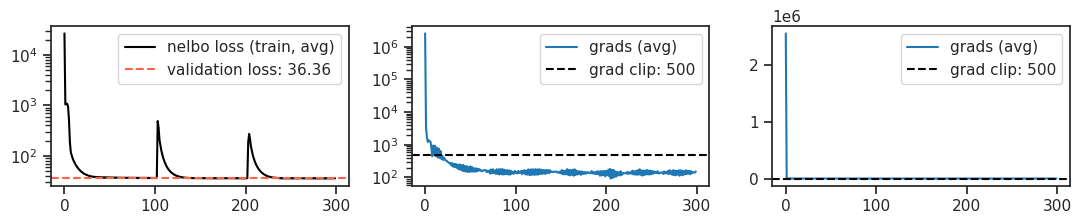

In [8]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=50)
plt.show()

In [9]:
spks, r_q, r_p, r_qp = [], [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['r_q']))
    r_p.append(to_np(out['r_p']))
    r_qp.append(to_np(out['r_q'] * out['r_p']))

spks, r_q, r_p, r_qp = cat_map([spks, r_q, r_p, r_qp])

In [10]:
np.quantile(spks.ravel(), 0.99)

732.0

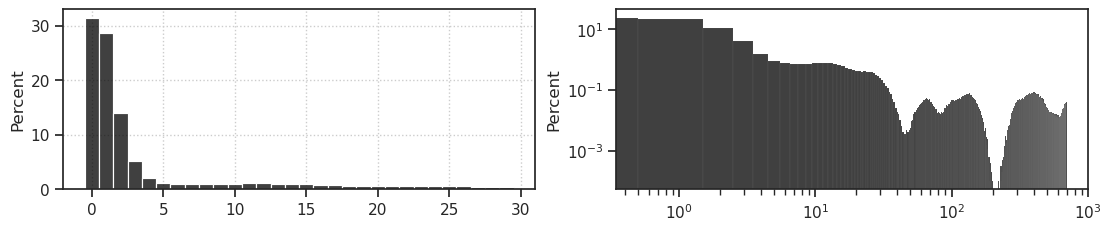

In [11]:
fig, axes = create_figure(1, 2, (11, 2.2), layout='constrained')

nbins = 30
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 700
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

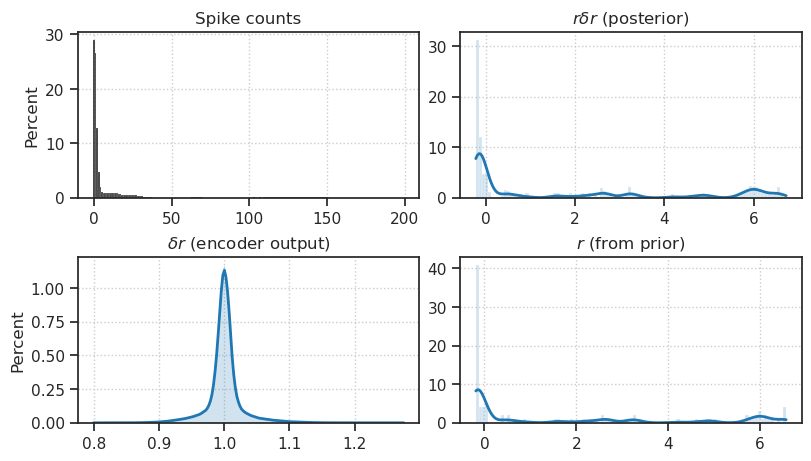

In [12]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 200
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
sns.histplot(np.log(r_p.ravel()), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

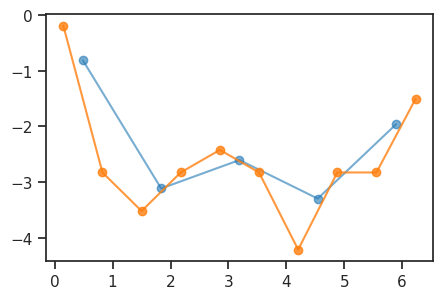

In [13]:
nbins_list = [5, 10]
for i, bins in enumerate(nbins_list):

    hist, bin_edges = np.histogram(np.log(r_p.ravel()), bins=bins, density=True)
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.plot(x, np.log(hist), marker='o', color=f'C{i}', alpha=1.0 - (len(nbins_list) - i) * 0.2)

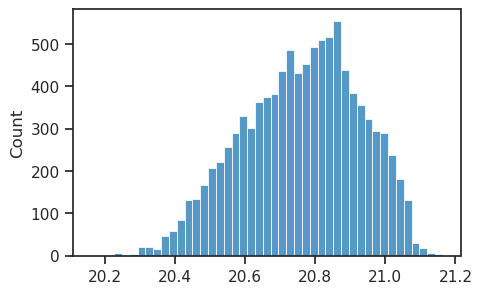

In [14]:
dispersion = ((r_qp).sum(1) ** 2) / (r_qp ** 2).sum(1)
sns.histplot(dispersion);

In [15]:
from torchvision.utils import make_grid

x_samples = pvae.sample(50)
grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 152, 302])

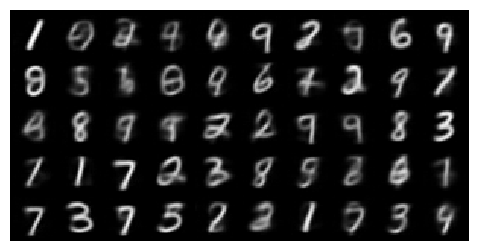

In [16]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (10, 3))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

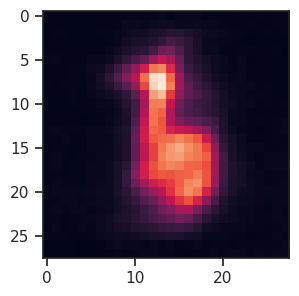

In [17]:
plt.imshow(to_np(x_samples[12].squeeze()));

In [18]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = pvae(x)

num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

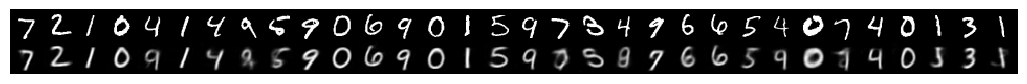

In [19]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

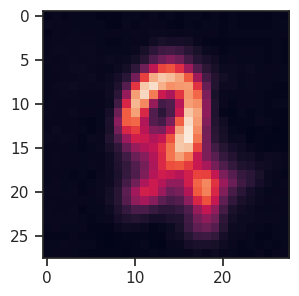

In [20]:
plt.imshow(to_np(out['x_recon'].squeeze()[7]));

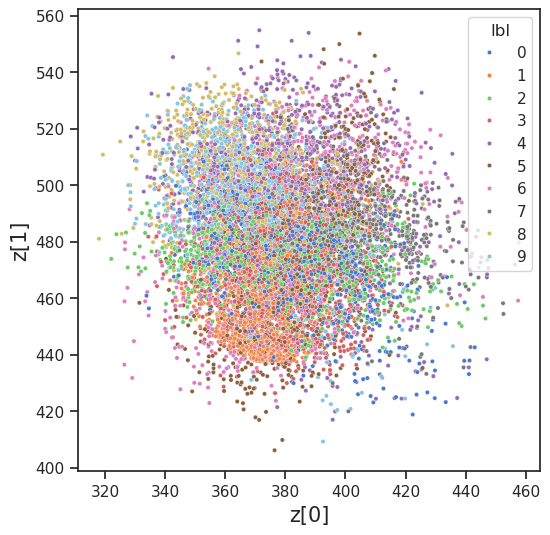

In [21]:
_ = plot_latent_scatter(emb, labels, (0, 2), (6, 6), 10)

In [22]:
uu, ss, vv = sp_lin.svd(emb, full_matrices=False)
ss *= 100 / sum(ss)
ss.shape

(100,)

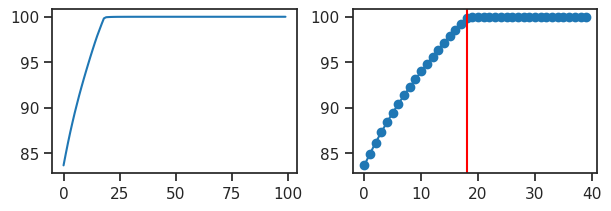

In [24]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')
axes[0].plot(np.cumsum(ss))
axes[1].plot(np.cumsum(ss)[:40], marker='o')
axes[1].axvline(18, color='r')
plt.show()
#, marker='o');

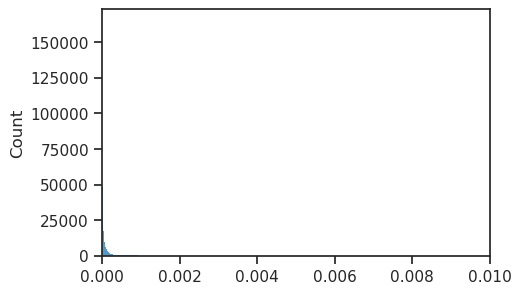

In [30]:
delta = 1 - r_q + r_q * np.log(r_q)
sns.histplot(delta.ravel())
plt.xlim(0, 0.01)
# plt.xlim(0, 0.3)
plt.show()

In [30]:
for x, lbl in iter(vld):
    x = x.to(device)
    break

spks, r_q, r_p, r_qp, x_recon = [], [], [], [], []
for _ in range(200):
    with torch.inference_mode():
        out = gapvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['r_q']))
    r_p.append(to_np(out['r_p']))
    r_qp.append(to_np(out['r_q'] * out['r_p']))
    x_recon.append(to_np(out['x_recon']))

spks, r_q, r_p, r_qp, x_recon = map(
    lambda arr: np.stack(arr),
    [spks, r_q, r_p, r_qp, x_recon],
)

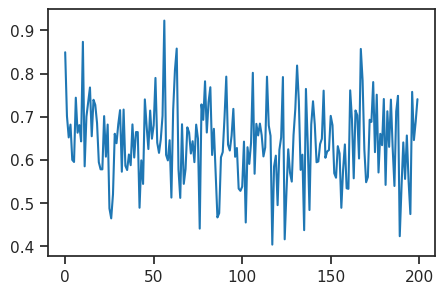

In [31]:
sample_i = 104
neuron_i = 10

plt.plot(spks[:, sample_i, neuron_i]);

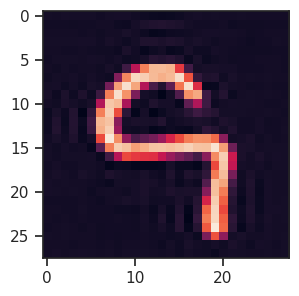

In [32]:
trial_i = 52
plt.imshow(x_recon[trial_i, sample_i, 0]);

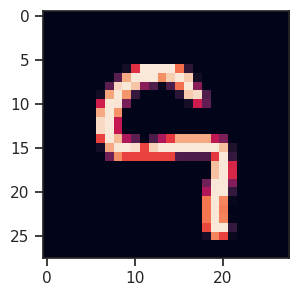

In [33]:
plt.imshow(to_np(x[sample_i, 0]));

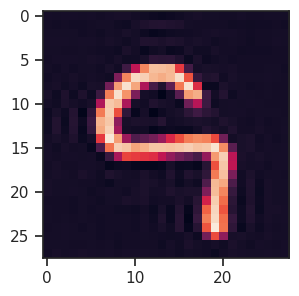

In [34]:
plt.imshow(x_recon[:, sample_i, 0].mean(0));

In [35]:
x_recon[:, sample_i, 0].shape

(200, 28, 28)

In [36]:
mse = torch.nn.functional.mse_loss(
    torch.tensor(x_recon[:, sample_i, 0], device=device),
    x[[sample_i], 0].expand(len(x_recon), -1, -1),
    reduction='none',
)
mse = torch.sum(mse, dim=[1, 2])
mse.shape

torch.Size([200])

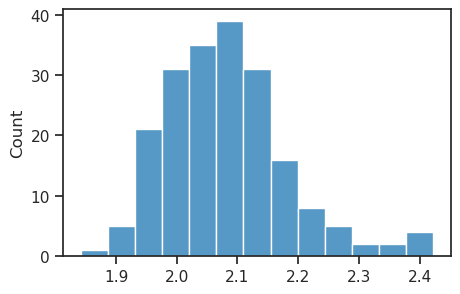

In [37]:
sns.histplot(to_np(mse));

In [38]:
gapvae.recon_loss_fn(x[sample_i, 0], torch.tensor(x_recon[:, sample_i, 0].mean(0), device=device))

tensor(1.9858, device='cuda:0')

In [ ]:
def explore_latent_space(n_partition=40):
    digit_size = 28
	figure = np.zeros((
		digit_size * n_partition,
		digit_size * n_partition,
	))
	grid_x = np.linspace(-scale, scale, n_partition)
	grid_y = np.linspace(-scale, scale, n_partition)[::-1]

	looper = itertools.product(
		enumerate(grid_y),
		enumerate(grid_x),
	)
	for (i, yi), (j, xi) in looper:
		z_sample = torch.tensor(
			data=[[xi, yi]],
			dtype=torch.float,
		).to(device)
		figure[
			i * digit_size: (i + 1) * digit_size,
			j * digit_size: (j + 1) * digit_size,
		] = to_np(decoder(z_sample).squeeze())

In [ ]:
_ = plot_latent_space(gapvae.dec, device, 2.0, 40)

In [16]:
span = np.arange(0, 101, 5)
grid = itertools.product(span, span)
grid = torch.tensor(
    np.array(list(grid)),
    dtype=torch.float,
    device=device,
)
len(span)

21

In [17]:
pvae.eval();
with torch.inference_mode():
    x_samples = pvae.dec(grid)

x_samples = to_np(x_samples.squeeze())
x_samples = x_samples.reshape(
    len(span), len(span), 28, 28)
x_samples.shape

(21, 21, 28, 28)

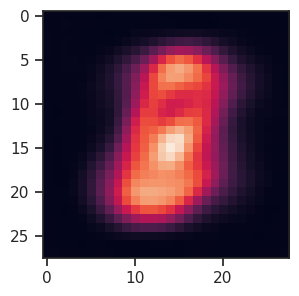

In [20]:
plt.imshow(x_samples[1, 1]);

In [143]:
num = 100

r = pvae.r.unsqueeze(0)
r = r.expand(num, -1)

In [150]:
spks = torch.poisson(r)
x_samples = pvae.dec(spks)
x_samples = to_np(x_samples.squeeze())
x_samples.shape

(100, 28, 28)

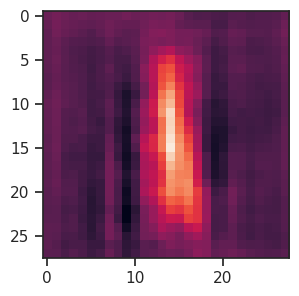

In [160]:
plt.imshow(x_samples[79]);

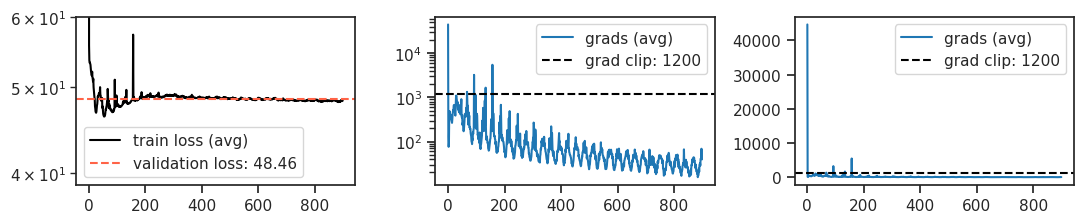

In [21]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(losses, color='k', label='train loss (avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(max_grad_norm, color='k', ls='--', label=f'grad clip: {max_grad_norm}')
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
axes[0].set_ylim(top=60)
plt.show()

### make some plots

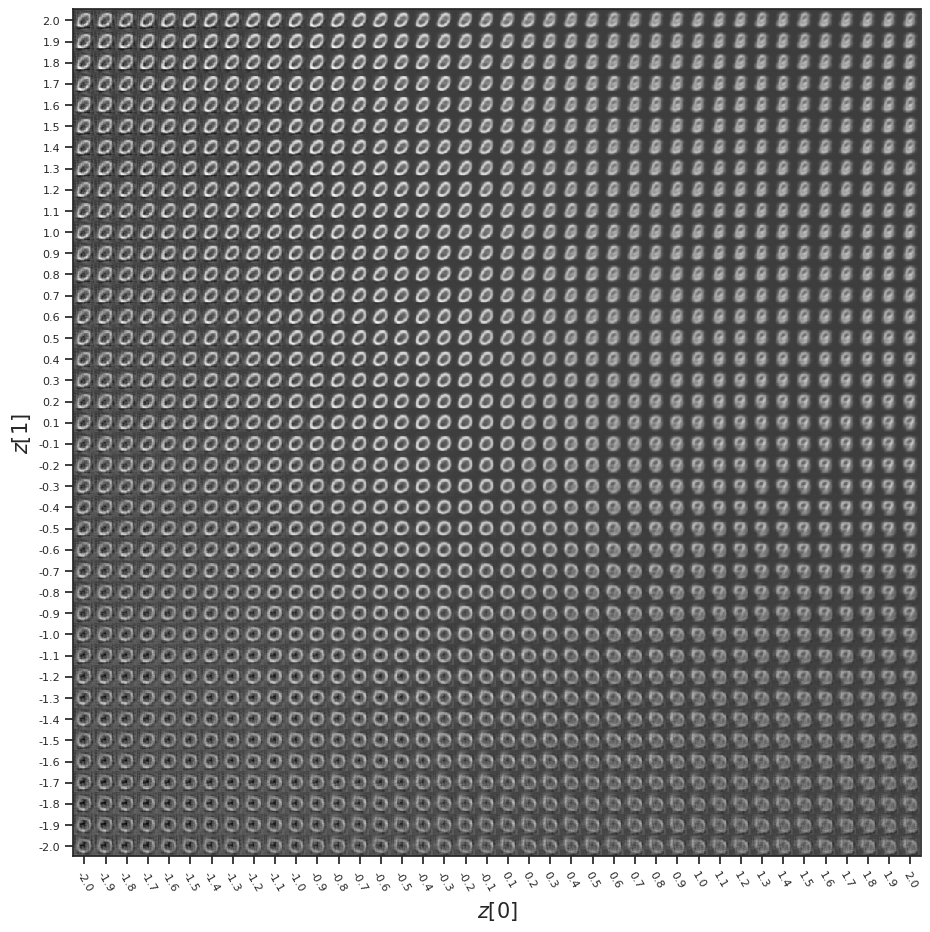

In [22]:
_ = plot_latent_space(pvae.dec, 2.0, 40)

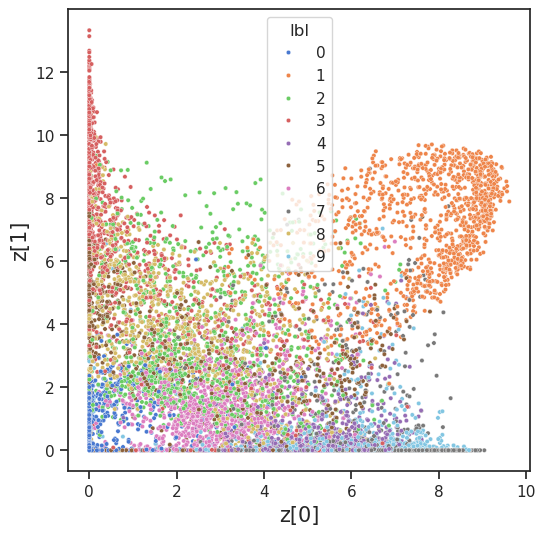

In [23]:
_ = plot_latent_scatter(emb, labels, (6, 6), 10)

In [25]:
print(inspect.getsource(pvae.forward)[-20:])

turn r, dr, x_recon

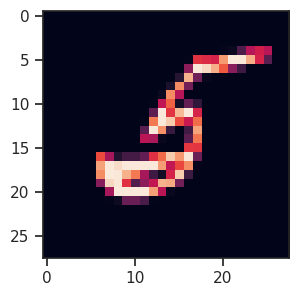

In [26]:
x, lbl = trn.dataset[1111]
plt.imshow(to_np(x)[0]);

In [27]:
with torch.inference_mode():
    r, dr, x_recon = pvae(x.unsqueeze(0).to(device))

In [28]:
num = 10000
posterior_dr = torch.zeros((num, 2))
posterior_full = torch.zeros((num, 2))

for i in range(num):
    posterior_dr[i] = torch.poisson(dr)
    posterior_full[i] = torch.poisson(r * dr)

prior = torch.zeros_like(posterior_full).log_normal_(
    pvae.mu, pvae.sd)

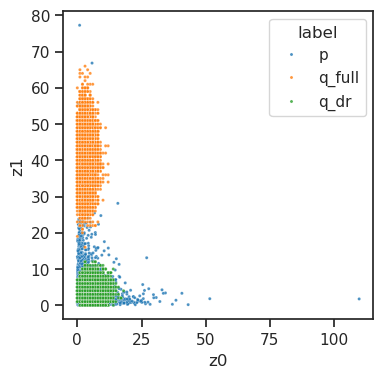

In [30]:
df = np.concatenate([prior, posterior_full, posterior_dr])
df = pd.DataFrame({
    'z0': df[:, 0],
    'z1': df[:, 1],
    'label': ['p'] * num + ['q_full'] * num + ['q_dr'] * num,
})

fig, ax = create_figure(1, 1, (4, 4))
sns.scatterplot(
    data=df,
    x='z0',
    y='z1',
    hue='label',
    palette={'p': 'C0', 'q_full': 'C1', 'q_dr': 'C2'},
    s=5,
    alpha=0.8,
    ax=ax,
)
plt.show()

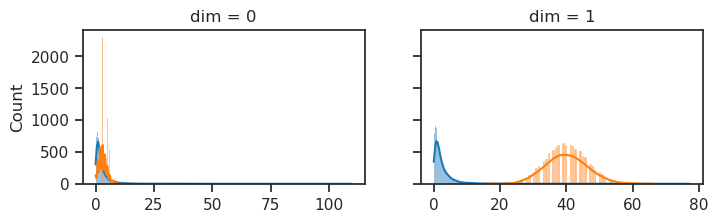

In [32]:
fig, axes = create_figure(1, 2, (8, 2), sharey='row')

for i in range(2):
    sns.histplot(prior[:, i], kde=True, ax=axes[i])
    sns.histplot(posterior_full[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'dim = {i}')
plt.show()

In [21]:
# path = '/home/hadi/Documents/vae'

# torch.save(
#     obj={'epoch': epochs,
#          'batch_size': batch_size,
#          'model_state_dict': gvae.state_dict(),
#          'optimizer_state_dict': optim.state_dict(),
#          'loss': loss_vld},
#     f=pjoin(path, '1.pt'),
# )